In [1]:
%matplotlib inline

import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.mlab import PCA
from sklearn.feature_selection import VarianceThreshold

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (16, 16)

## Очистка данных

In [2]:
df = pd.read_csv('dataset_16_2', header=None, sep='\t', na_values='-')
df = df.loc[:, 2:]
df.head()

,2,3,4,5,6,7,8,9,10,11,...,45,46,47,48,49,50,51,52,53,54
0,1429627313,162,86401.0,25910,6,13,0.0,64,1,1,...,1.0,3.0,0.0,3.0,100.0,NaN,NaN,0.0,0.0,2
1,1443635700,0,NaN,6971,8,10,NaN,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,1443653041,0,NaN,1825,1,2,NaN,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1405667008,439,NaN,15,9,9,NaN,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1430733562,150,86401.0,29562,13,21,0.0,17,1,1,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,1


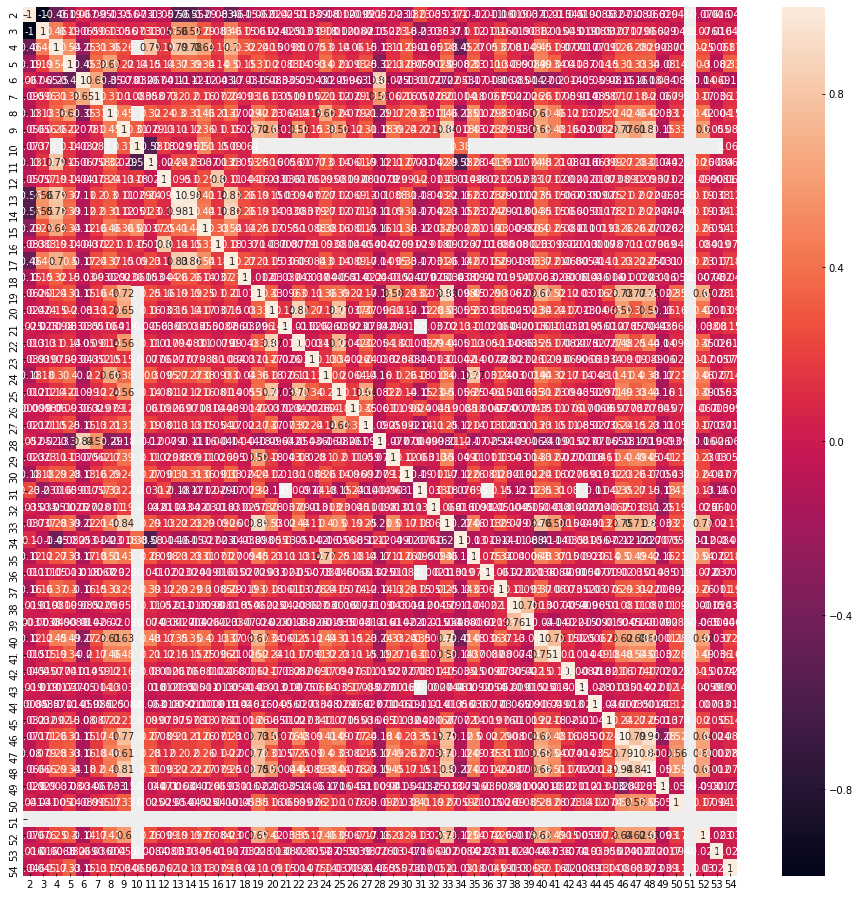

In [3]:
sns.heatmap(df.corr(), annot=True);

In [4]:
df.drop([10, 51], axis=1, inplace=True)
df.head()

,2,3,4,5,6,7,8,9,11,12,...,44,45,46,47,48,49,50,52,53,54
0,1429627313,162,86401.0,25910,6,13,0.0,64,1,0,...,5.0,1.0,3.0,0.0,3.0,100.0,NaN,0.0,0.0,2
1,1443635700,0,NaN,6971,8,10,NaN,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,1443653041,0,NaN,1825,1,2,NaN,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1405667008,439,NaN,15,9,9,NaN,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1430733562,150,86401.0,29562,13,21,0.0,17,1,0,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,1


In [5]:
pca1 = PCA(df.fillna(0))
print(np.round(pca1.fracs, 2))  # Explained variance

[ 0.26  0.09  0.06  0.04  0.04  0.03  0.03  0.03  0.03  0.03  0.03  0.02
  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.  ]


Возмем первые вектора с variance >= 0.03 и соответствующие ему колонки (хорошо скоррелированые).

In [6]:
m = sum(pca1.fracs >= 0.04)
p = pd.DataFrame(pca1.Wt.T).iloc[:, :m]
columns = np.where(np.any(p >= 0.2, 1))[0]
df.columns[columns]

Int64Index([2, 11, 20, 22, 25, 47], dtype='int64')

In [7]:
df = df.iloc[:, df.columns[columns]]
df.columns = range(len(df.columns))
df = df.fillna(0)
df.head()

,0,1,2,3,4,5
0,86401.0,56,0.0,0.0,1.443671e+09,0.0
1,0.0,2,0.0,0.0,0.000000e+00,0.0
2,0.0,1,0.0,0.0,0.000000e+00,0.0
3,0.0,56,0.0,0.0,0.000000e+00,0.0
4,86401.0,56,0.0,0.0,0.000000e+00,0.0


In [8]:
df.describe()

,0,1,2,3,4,5
count,9096.000000,9096.000000,9096.000000,9096.000000,9.096000e+03,9096.000000
mean,11513.614336,20.530343,0.055189,0.094657,2.120466e+08,0.423923
std,29258.291992,23.203480,1.210650,0.999588,5.110728e+08,2.644553
min,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000
50%,0.000000,3.000000,0.000000,0.000000,0.000000e+00,0.000000
75%,0.000000,49.000000,0.000000,0.000000,0.000000e+00,0.000000
max,86401.000000,56.000000,49.000000,37.000000,1.443733e+09,50.000000


## Чистим строки

In [9]:
p1, p5, p95, p99 = [], [], [], []
N, K = df.shape

for i in range(K):
    p1.append(np.percentile(df[i], 1))
    p5.append(np.percentile(df[i], 5))
    p95.append(np.percentile(df[i], 95))
    p99.append(np.percentile(df[i], 99))

abnormality = {}
for i in range(N):
    abnormality[i] = 0
    for j in range(K):
        c = df.iloc[i, j]
        # 1 point of abnormalito for getting into top or bottom 5%
        # +2 extra points of abnormality for getting into top or bottom 1%
        abnormality[i] += 2 * (c < p1[j]) + (c < p5[j]) + (c > p95[j]) + 2 * (c > p99[j])

abn_sorted = sorted(abnormality.items(), key=lambda x: x[1], reverse=True)
for k, v in abn_sorted[:10]:
    print(k, v)

456 9
2836 9
97 7
643 7
1829 7
2896 7
3148 7
4080 7
4553 7
4584 7


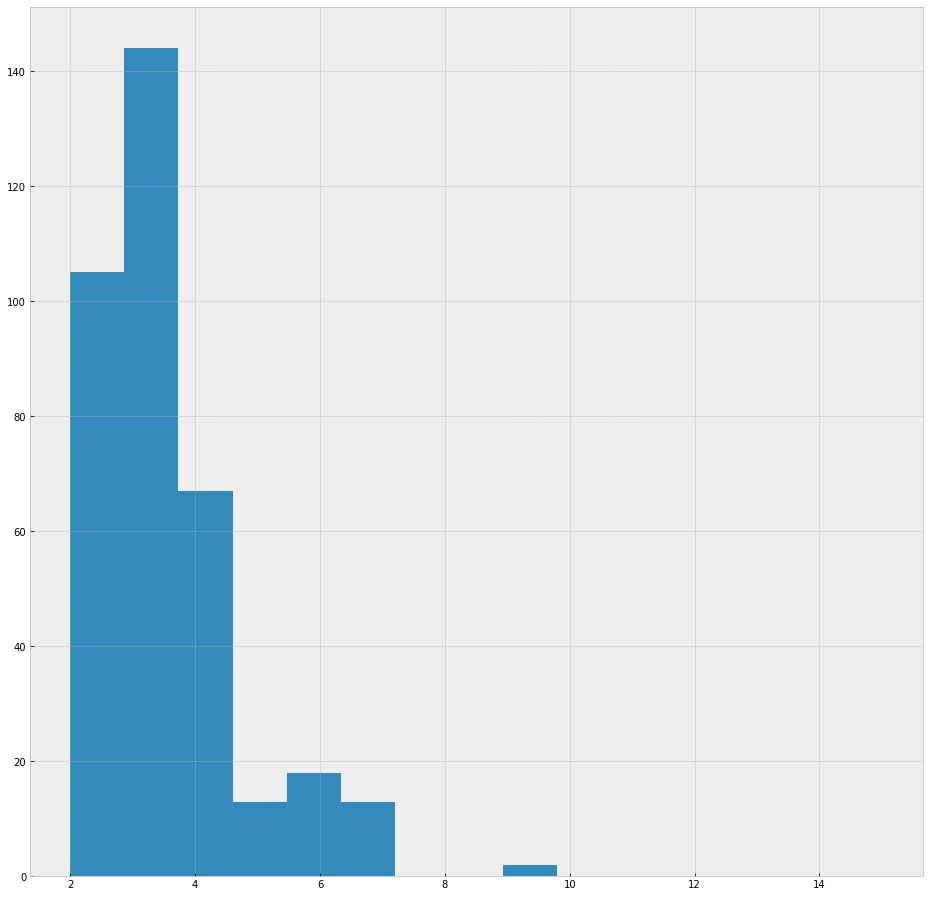

In [10]:
plt.hist(abnormality.values(), 15, range=[2, 15]);

In [11]:
vals = np.array(list(abnormality.values()))
vals.mean(), vals.std()

(0.18018909410729991, 0.7197177445287789)

In [12]:
df = df.iloc[np.array([k for k, v in abnormality.items() if v >= 2]), :]

## Кластеризация (TODO...)

In [13]:
centroid, label = scipy.cluster.vq.kmeans2(df.as_matrix().T, 5, iter=100, 
                                           thresh=1e-05, minit='random', missing='warn')

/Users/stasbel/.virtualenvs/pracanalytics-hw-64oIrb4y/lib/python3.6/site-packages/scipy/cluster/vq.py:523: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


In [14]:
assert len(np.unique(label)) > 2

AssertionError: 

In [ ]:
df_abn = pd.DataFrame(list(abnormality.values()), columns=[['abn']])
df_label = pd.DataFrame(label, columns=[['cluster_id']])
cluster_stats = pd.concat([df_abn, df_label], axis=1).pivot_table(
    index='cluster_id',
    values='abn',
    aggfunc=[len, np.mean, np.std, np.var]
)

# reorder axis to make cluster_stats look simpler
cluster_stats2 = cluster_stats.reorder_levels([1,0], axis=1)['abn']
cluster_stats2